# Generating TFRecord for the images and the captions of the images

The images and their annotated two captions are considered and transformed into a TFRecord 

## Import the required libraries

In [ ]:
import os
import json
import pprint
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download the COCO2017 dataset

We will be using the [COCO2017](https://cocodataset.org/) dataset, because it has many
different types of features, including images, floating point data, and lists.
It will serve as a good example of how to encode different features into the TFRecord
format.

This dataset has two sets of fields: images and annotation meta-data.

The images are a collection of JPG files and the meta-data are stored in a JSON file
which, according to the [official site](https://cocodataset.org/#format-data),
contains the following properties:

```
id: int,
image_id: int,
category_id: int,
segmentation: RLE or [polygon], object segmentation mask
bbox: [x,y,width,height], object bounding box coordinates
area: float, area of the bounding box
iscrowd: 0 or 1, is single object or a collection
```

In [ ]:
root_dir = "datasets"
tfrecords_dir = "/content/drive/Shareddrives/Project_258_dataset/tfrecords_1"
images_dir = os.path.join(root_dir, "val2017")
annotations_dir = os.path.join(root_dir, "annotations")
annotation_file = os.path.join(annotations_dir, "instances_val2017.json")
images_url = "http://images.cocodataset.org/zips/val2017.zip"
annotations_url = (
    "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
)

# Download image files
if not os.path.exists(images_dir):
    image_zip = tf.keras.utils.get_file(
        "images.zip", cache_dir=os.path.abspath("."), origin=images_url, extract=True,
    )
    os.remove(image_zip)

# Download caption annotation files
if not os.path.exists(annotations_dir):
    annotation_zip = tf.keras.utils.get_file(
        "captions.zip",
        cache_dir=os.path.abspath("."),
        origin=annotations_url,
        extract=True,
    )
    os.remove(annotation_zip)

print("The COCO dataset has been downloaded and extracted successfully.")

with open(annotation_file, "r") as f:
    annotations = json.load(f)["annotations"]

print(f"Number of images: {len(annotations)}")

252911616/252907541 [==============================] - 3s 0us/step
The COCO dataset has been downloaded and extracted successfully.
Number of images: 36781


In [ ]:
a = os.path.join(annotations_dir, "captions_val2017.json")

with open(a, "r") as f:
    cap = json.load(f)

In [ ]:
cap['annotations']

[{'caption': 'A black Honda motorcycle parked in front of a garage.',
  'id': 38,
  'image_id': 179765},
 {'caption': 'A Honda motorcycle parked in a grass driveway',
  'id': 182,
  'image_id': 179765},
 {'caption': 'An office cubicle with four different types of computers.',
  'id': 401,
  'image_id': 190236},
 {'caption': 'A small closed toilet in a cramped space.',
  'id': 441,
  'image_id': 331352},
 {'caption': 'Two women waiting at a bench next to a street.',
  'id': 447,
  'image_id': 517069},
 {'caption': 'A black Honda motorcycle with a dark burgundy seat.',
  'id': 479,
  'image_id': 179765},
 {'caption': 'A tan toilet and sink combination in a small room.',
  'id': 540,
  'image_id': 331352},
 {'caption': 'The home office space seems to be very cluttered.',
  'id': 644,
  'image_id': 190236},
 {'caption': 'A beautiful dessert waiting to be shared by two people',
  'id': 856,
  'image_id': 182417},
 {'caption': 'A woman sitting on a bench and a woman standing waiting for the 

In [ ]:
print(len(cap['annotations']))

25014


### Contents of the COCO2017 dataset

In [ ]:
annotations

[{'area': 702.1057499999998,
  'bbox': [473.07, 395.93, 38.65, 28.67],
  'category_id': 18,
  'id': 1768,
  'image_id': 289343,
  'iscrowd': 0,
  'segmentation': [[510.66,
    423.01,
    511.72,
    420.03,
    510.45,
    416.0,
    510.34,
    413.02,
    510.77,
    410.26,
    510.77,
    407.5,
    510.34,
    405.16,
    511.51,
    402.83,
    511.41,
    400.49,
    510.24,
    398.16,
    509.39,
    397.31,
    504.61,
    399.22,
    502.17,
    399.64,
    500.89,
    401.66,
    500.47,
    402.08,
    499.09,
    401.87,
    495.79,
    401.98,
    490.59,
    401.77,
    488.79,
    401.77,
    485.39,
    398.58,
    483.9,
    397.31,
    481.56,
    396.35,
    478.48,
    395.93,
    476.68,
    396.03,
    475.4,
    396.77,
    473.92,
    398.79,
    473.28,
    399.96,
    473.49,
    401.87,
    474.56,
    403.47,
    473.07,
    405.59,
    473.39,
    407.71,
    476.68,
    409.41,
    479.23,
    409.73,
    481.56,
    410.69,
    480.4,
    411.85,
    4

In [ ]:
pprint.pprint(annotations[60])

{'area': 367.89710000000014,
 'bbox': [265.67, 222.31, 26.48, 14.71],
 'category_id': 72,
 'id': 34096,
 'image_id': 525083,
 'iscrowd': 0,
 'segmentation': [[267.51,
                   222.31,
                   292.15,
                   222.31,
                   291.05,
                   237.02,
                   265.67,
                   237.02]]}


## Parameters

`num_samples` is the number of data samples on each TFRecord file.

`num_tfrecods` is total number of TFRecords that we will create.

In [ ]:
num_samples = 4096
num_tfrecods = len(annotations) // num_samples
if len(annotations) % num_samples:
    num_tfrecods += 1  # add one record if there are any remaining samples

if not os.path.exists(tfrecords_dir):
    os.makedirs(tfrecords_dir)  # creating TFRecords output folder

## Define TFRecords helper functions

For generating Tfrecord of images and the its captions as the labels, each feature is casted to the tensworflow object. Two captions for each image are considered as labels( caption_1 caption_2).  Below are features considered in the tfrecord:

* image 
* path
* area
* bbox
* category_id
* id
* image_id
* caption_1
* caption_2



In [ ]:
train_captions=[]
for i in range(len(cap['annotations'])):
  train_captions.append(cap['annotations'][i]['caption'])


In [ ]:
def calc_max_length(tensor):
  return max(len(t) for t in tensor)

# Performing tokenization on the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, 
oov_token="<unk>", 
filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

# Converting text into sequence of numbers
tokenizer.fit_on_texts(train_captions) # Updates internal vocabulary based on a list of texts.
train_seqs = tokenizer.texts_to_sequences(train_captions) #with its corresponding integer value from the word_index dictionary

tokenizer.word_index = {key:value for key, value in tokenizer.word_index.items() if value <= top_k}

# putting <unk> token in the word2idx dictionary
tokenizer.word_index[tokenizer.oov_token] = top_k + 1
tokenizer.word_index['<pad>'] = 0

# creating the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)
#print(train_seqs)

# creating a reverse mapping (index -> word)
index_word = {value:key for key, value in tokenizer.word_index.items()}

# padding each vector to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# calculating the max_length 
# used to store the attention weights
max_length = calc_max_length(train_seqs)

#print(tokenizer.texts_to_sequences(cap['annotations'][0]['caption']))
#print(tokenizer)

In [ ]:
def tokenization(train_caption): 
  train_seqs = tokenizer.texts_to_sequences(train_captions)
  return train_seqs


In [ ]:

def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )


def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def captions(image_id):
  lis=[]
  #print(tokenizer)
  for x in range(len(cap['annotations'])):
    if(cap['annotations'][x]['image_id']==image_id):
      #tok=tokenization(cap['annotations'][x]['caption'])
      c=cap['annotations'][x]['caption']
      lis.append(tf.train.Feature(
        bytes_list=tf.train.BytesList(
            value=[c.encode('utf-8')])))
      #print(cap['annotations'][x]['caption'])
  #print(tf.compat.as_bytes(l))
  print(lis)   
  return lis


def create_example(image, path, example):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "area": float_feature(example["area"]),
        "bbox": float_feature_list(example["bbox"]),
        "category_id": int64_feature(example["category_id"]),
        "id": int64_feature(example["id"]),
        "image_id": int64_feature(example["image_id"]),
        "caption_1": captions(example["image_id"])[0],
        "caption_2": captions(example["image_id"])[1],
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "area": tf.io.FixedLenFeature([], tf.float32),
        "bbox": tf.io.VarLenFeature(tf.float32),
        "category_id": tf.io.FixedLenFeature([], tf.int64),
        "id": tf.io.FixedLenFeature([], tf.int64),
        "image_id": tf.io.FixedLenFeature([], tf.int64),
        "caption_1": tf.io.VarLenFeature(dtype=tf.string),
        "caption_2": tf.io.VarLenFeature(dtype=tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["bbox"] = tf.sparse.to_dense(example["bbox"])
    return example


## Generate data in the TFRecord format

Let's generate the COCO2017 data in the TFRecord format. The format will be
`file_{number}.tfrec` (this is optional, but including the number sequences in the file
names can make counting easier).

In [ ]:
for tfrec_num in range(num_tfrecods):
    samples = annotations[(tfrec_num * num_samples) : ((tfrec_num + 1) * num_samples)]

    with tf.io.TFRecordWriter(
        tfrecords_dir + "/file_%.2i-%i.tfrec" % (tfrec_num, len(samples))
    ) as writer:
        for sample in samples:
            image_path = f"{images_dir}/{sample['image_id']:012d}.jpg"
            image = tf.io.decode_jpeg(tf.io.read_file(image_path))
            example = create_example(image, image_path, sample)
            writer.write(example.SerializeToString())

Streaming output truncated to the last 5000 lines.
}
, bytes_list {
  value: "An athlete is performing on a sports field."
}
, bytes_list {
  value: "some baseball players a batter catcher and an umpire"
}
]
[bytes_list {
  value: "Outdoor show with sheep prominent on grass field."
}
, bytes_list {
  value: "a couple of people that are walking in some grass"
}
, bytes_list {
  value: "A sheep running through the field of an event."
}
, bytes_list {
  value: "A sheep is walking along a wide field."
}
, bytes_list {
  value: "A sheep is on a field of grass with two men walking around it."
}
]
[bytes_list {
  value: "Outdoor show with sheep prominent on grass field."
}
, bytes_list {
  value: "a couple of people that are walking in some grass"
}
, bytes_list {
  value: "A sheep running through the field of an event."
}
, bytes_list {
  value: "A sheep is walking along a wide field."
}
, bytes_list {
  value: "A sheep is on a field of grass with two men walking around it."
}
]
[bytes_list 

## Explore one sample from the generated TFRecord

bbox: [473.07 395.93  38.65  28.67]
caption_1: SparseTensor(indices=tf.Tensor([[0]], shape=(1, 1), dtype=int64), values=tf.Tensor([b'A man is riding a large bike through the park.'], shape=(1,), dtype=string), dense_shape=tf.Tensor([1], shape=(1,), dtype=int64))
caption_2: SparseTensor(indices=tf.Tensor([[0]], shape=(1, 1), dtype=int64), values=tf.Tensor([b'A person riding a very tall bike in the street.'], shape=(1,), dtype=string), dense_shape=tf.Tensor([1], shape=(1,), dtype=int64))
area: 702.1057739257812
category_id: 18
id: 1768
image_id: 289343
path: b'datasets/val2017/000000289343.jpg'
Image shape: (640, 529, 3)


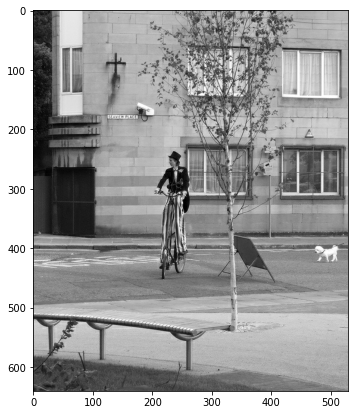

In [ ]:
raw_dataset = tf.data.TFRecordDataset(f"{tfrecords_dir}/file_00-{num_samples}.tfrec")
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    #print(label = tf.io.deserialize_many_sparse(features['cations'],tf.int64))
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()